In [0]:
!pip install numpy==1.15.1

    100% |████████████████████████████████| 13.9MB 3.7MB/s 
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.16.2
    Uninstalling numpy-1.16.2:
      Successfully uninstalled numpy-1.16.2


In [0]:
from numpy import quantile


In [0]:
# Connect Google drive with the colab
from google.colab import drive
drive.mount('/content/drive')
import os
os.listdir('/content/drive/My Drive/DL_Final_Proj')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


['train.csv',
 'sample_submission.csv',
 'test',
 'submission.csv',
 'Copy of Earthquake.ipynb',
 'X_tr',
 'y_tr',
 'submission_gru_48features.csv',
 'model',
 'Earthquake.ipynb',
 'submission_gru_36_features_correct.csv',
 'submission_lstm_36_features.csv',
 'submission_cnn_lstm_36_features_10_epoch.csv',
 'submission_cnn_lstm_36_features_20_epoch.csv',
 'submission_cnn_lstm_36_features_30_epoch.csv',
 'submission_avg.csv',
 '0.2lgbm_ensemble_0.8submission.csv',
 'submission_avg_4.csv',
 'blend_ver4.csv',
 'submission_avg_magic.csv',
 'ensemble_nn_x_train',
 'ensemble_nn_y_train',
 'models',
 'LightGBM.ipynb',
 'Earthquake CNN LSTM 36 Features.ipynb',
 'submission_stacked.csv',
 'Ensemble_NN.ipynb',
 'submission_stack_lgbm_nn.csv',
 'submission_stack_lgbm_nn_blend.csv',
 'Stack Model.ipynb',
 'Untitled4.ipynb',
 'Earthquake CNN 36 Features.ipynb',
 'Earthquake LSTM 36 features.ipynb']

In [0]:
root = '/content/drive/My Drive/DL_Final_Proj/'

In [0]:
# BASIC IDEA OF THE KERNEL

# The data consists of a one dimensional time series x with 600 Mio data points. 
# At test time, we will see a time series of length 150'000 to predict the next earthquake.
# The idea of this kernel is to randomly sample chunks of length 150'000 from x, derive some
# features and use them to update weights of a recurrent neural net with 150'000 / 1000 = 150
# time steps. 

import numpy as np 
import pandas as pd
import os
from tqdm import tqdm

# Fix seeds
from numpy.random import seed
seed(639)
from tensorflow import set_random_seed
set_random_seed(5944)

# Import
float_data = pd.read_csv(root + "train.csv", dtype={"acoustic_data": np.float32, "time_to_failure": np.float32}).values

In [0]:
import numpy as np 
from scipy.stats import kurtosis, skew
from scipy.signal import hilbert
# Helper function for the data generator. Extracts mean, standard deviation, and quantiles per time step.
# Can easily be extended. Expects a two dimensional array.
def extract_features(z):
#       z_std = z.std(axis=1)
#       z_mean = z.mean(axis=1)
#       print(z.mean(axis=1))
#       x_roll_mean = x.rolling(windows).mean().dropna().values
      return np.c_[z.mean(axis=1), 
                  z.min(axis=1),
                  z.max(axis=1),
                  z.std(axis=1),
                  z.sum(axis=1),
                  np.abs(z).max(axis=1),
                  np.abs(z).min(axis=1),
                  np.quantile(z, 0.01, axis=1),
                  np.quantile(z, 0.05, axis=1),
                  np.quantile(z, 0.95, axis=1),
                  np.quantile(z, 0.99, axis=1),
                  np.mean((np.diff(z, axis=1)),axis=1)]

# For a given ending position "last_index", we split the last 150'000 values 
# of "x" into 150 pieces of length 1000 each. So n_steps * step_length should equal 150'000.
# From each piece, a set features are extracted. This results in a feature matrix 
# of dimension (150 time steps x features).  
def create_X(x, last_index=None, n_steps=150, step_length=1000):
    if last_index == None:
        last_index=len(x)
       
    assert last_index - n_steps * step_length >= 0

    # Reshaping and approximate standardization with mean 5 and std 3.
    temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1) - 5 ) / 3
    
    # Extracts features of sequences of full length 1000, of the last 100 values and finally also 
    # of the last 10 observations. 
    return np.c_[extract_features(temp), extract_features(temp[:, -step_length // 10:]), extract_features(temp[:, -step_length // 100:])]
#     print(window_features.shape)
#     print(np.expand_dims((np.transpose([temp.mean()]*150)), 1).shape)
# Query "create_X" to figure out the number of features
n_features = create_X(np.zeros(150000)).shape[1]
print("Our RNN is based on %i features"% n_features)

Our RNN is based on 36 features


In [0]:
# The generator endlessly selects "batch_size" ending positions of sub-time series. For each ending position,
# the "time_to_failure" serves as target, while the features are created by the function "create_X".
def generator(data, min_index=0, max_index=None, batch_size=16, n_steps=150, step_length=1000):
    if max_index is None:
        max_index = len(data) - 1
     
    while True:
        # Pick indices of ending positions
        rows = np.random.randint(min_index + n_steps * step_length, max_index, size=batch_size)
         
        # Initialize feature matrices and targets
        samples = np.zeros((batch_size, n_steps, n_features))
        targets = np.zeros(batch_size, )
        
        for j, row in enumerate(rows):
            samples[j] = create_X(data[:, 0], last_index=row, n_steps=n_steps, step_length=step_length)
            targets[j] = data[row - 1, 1]
        yield samples, targets
        
batch_size = 32

# Position of second (of 16) earthquake. Used to have a clean split
# between train and validation
second_earthquake = 50085877
float_data[second_earthquake, 1]

# Initialize generators
train_gen = generator(float_data, batch_size=batch_size) # Use this for better score
# train_gen = generator(float_data, batch_size=batch_size, min_index=second_earthquake + 1)
valid_gen = generator(float_data, batch_size=batch_size, max_index=second_earthquake)


In [0]:
# Define model
from keras.models import Sequential
from keras.layers import Dense, CuDNNGRU, CuDNNLSTM, RNN
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint

cb = [ModelCheckpoint("model.hdf5", save_best_only=True, period=3)]
model = Sequential()
model.add(CuDNNLSTM(48,return_sequences=True, input_shape=(None, n_features)))
model.add(CuDNNLSTM(36,return_sequences=True))
model.add(CuDNNLSTM(24, input_shape=(None, n_features)))
model.add(Dense(100, activation='relu'))
model.add(Activation(activation))
model.add(BatchNormalization())
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_7 (CuDNNLSTM)     (None, None, 48)          16512     
_________________________________________________________________
cu_dnnlstm_8 (CuDNNLSTM)     (None, None, 36)          12384     
_________________________________________________________________
cu_dnnlstm_9 (CuDNNLSTM)     (None, 24)                5952      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               2500      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 38,369
Trainable params: 38,369
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1000/1000 [==============================] - 456s 456ms/step - loss: 2.5829 - val_loss: 1.9581
Epoch 2/10
1000/1000 [==============================] - 451s 451ms/step - loss: 2.2588 - val_loss: 1.9864
Epoch 3/10
1000/1000 [==============================] - 429s 429ms/step - loss: 2.1606 - val_loss: 1.8473
Epoch 4/10
1000/1000 [==============================] - 438s 438ms/step - loss: 2.1011 - val_loss: 1.8039
Epoch 5/10
1000/1000 [==============================] - 427s 427ms/step - loss: 2.1199 - val_loss: 1.7663
Epoch 6/10
1000/1000 [==============================] - 428s 428ms/step - loss: 2.0974 - val_loss: 1.7413
Epoch 7/10
1000/1000 [==============================] - 424s 424ms/step - loss: 2.0861 - val_loss: 1.6649
Epoch 8/10
1000/1000 [==============================] - 427s 427ms/step - loss: 2.1046 - val_loss: 1.8155
Epoch 9/10
1000/1000 [==============================] - 427s 427ms/step - loss: 2.1058 - val_loss: 1.719

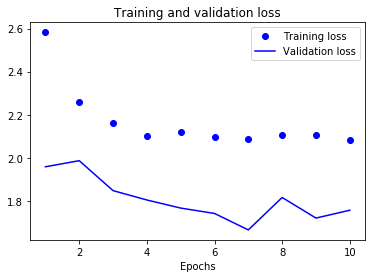

In [0]:
# Compile and fit model
model.compile(optimizer=adam(lr=0.0005), loss="mae")

history = model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=10,
                              verbose=1,
                              callbacks=cb,
                              validation_data=valid_gen,
                              validation_steps=200)

# Visualize accuracies
import matplotlib.pyplot as plt


def perf_plot(history, what = 'loss'):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1
    
    plt.plot(epochs, x, 'bo', label = "Training " + what)
    plt.plot(epochs, val_x, 'b', label = "Validation " + what)
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    return None

perf_plot(history)

In [0]:
model.save(root+'models/model_5.h5')

In [0]:
from keras.models import load_model
model = load_model(root+'models/model_6.h5')
# Load submission file
submission = pd.read_csv(root + 'sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

# Load each test data, create the feature matrix, get numeric prediction
for i, seg_id in enumerate(tqdm(submission.index)):
  #  print(i)
    seg = pd.read_csv(root + 'test/' + seg_id + '.csv')
    x = seg['acoustic_data'].values
    submission.time_to_failure[i] = model.predict(np.expand_dims(create_X(x), 0))

submission.head()

# Save
submission.to_csv(root +'submission_lstm_stacked_64_32.csv')


100%|██████████| 2624/2624 [02:30<00:00, 17.41it/s]

In [0]:
from keras.models import load_model
model1 = load_model(root+'models/model_3.h5')

In [0]:

from keras.models import load_model
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
from numpy import argmax
from keras.models import Sequential
from keras.layers import CuDNNGRU, CuDNNLSTM
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint

# load models from file
def load_all_models(n_models):
	all_models = list()
	for i in [1, 3, 4, 5, 6]:
		# define filename for this ensemble
		filename = root + 'models/model_' + str(i) + '.h5'
		# load model from file
		model = load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models
 
# define stacked model from multiple member input models
def define_stacked_model(members):
	# update all layers in all models to not be trainable
	for i in range(len(members)):
		model = members[i]
		for layer in model.layers:
			# make not trainable
			layer.trainable = False
			# rename to avoid 'unique layer name' issue
			layer.name = 'ensemble_' + str(i+1) + '_' + layer.name
	# define multi-headed input
	ensemble_visible = [model.input for model in members]
	# concatenate merge output from each model
	ensemble_outputs = [model.output for model in members]
	merge = concatenate(ensemble_outputs)
	hidden = Dense(10, activation='relu')(merge)
	output = Dense(1, activation='relu')(hidden)
	model = Model(inputs=ensemble_visible, outputs=output)
	plot_model(model, show_shapes=True, to_file='model_graph.png')
	# compile
	model.compile(loss="mae", optimizer='adam', metrics=['accuracy'])
	return model
 
  
 

In [0]:
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))
# define ensemble model
stacked_model = define_stacked_model(members)

>loaded /content/drive/My Drive/DL_Final_Proj/models/model_1.h5
>loaded /content/drive/My Drive/DL_Final_Proj/models/model_3.h5
>loaded /content/drive/My Drive/DL_Final_Proj/models/model_4.h5
>loaded /content/drive/My Drive/DL_Final_Proj/models/model_5.h5
>loaded /content/drive/My Drive/DL_Final_Proj/models/model_6.h5
Loaded 5 models


In [0]:
stacked_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_1_input (InputLayer)     (None, None, 36)     0                                            
__________________________________________________________________________________________________
ensemble_3_conv1d_1 (Conv1D)    (None, None, 32)     3488        conv1d_1_input[0][0]             
__________________________________________________________________________________________________
ensemble_3_max_pooling1d_1 (Max (None, None, 32)     0           ensemble_3_conv1d_1[0][0]        
__________________________________________________________________________________________________
cu_dnnlstm_7_input (InputLayer) (None, None, 36)     0                                            
__________________________________________________________________________________________________
ensemble_3

In [0]:
import pickle
x_train_model_2 = pickle.load(root+'ensemble_nn_x_train')
x_train_model_2.shape

TypeError: ignored

In [0]:
def stacked_generator(data, min_index=0, max_index=None, batch_size=16, n_steps=150, step_length=1000):
    if max_index is None:
        max_index = len(data) - 1
     
    while True:
        # Pick indices of ending positions
        rows = np.random.randint(min_index + n_steps * step_length, max_index, size=batch_size)
         
        # Initialize feature matrices and targets
        samples = np.zeros((batch_size, n_steps, n_features))
        targets = np.zeros(batch_size, )
        
        for j, row in enumerate(rows):
            samples[j] = create_X(data[:, 0], last_index=row, n_steps=n_steps, step_length=step_length)
            targets[j] = data[row - 1, 1]
        yield [samples]*5, targets
        
batch_size = 32

# Position of second (of 16) earthquake. Used to have a clean split
# between train and validation
second_earthquake = 50085877
float_data[second_earthquake, 1]

# Initialize generators
# stacked_train_gen = generator(float_data, batch_size=batch_size) # Use this for better score
# train_gen = generator(float_data, batch_size=batch_size, min_index=second_earthquake + 1)
stacked_val_gen = stacked_generator(float_data, batch_size=batch_size, max_index=second_earthquake)
stacked_train_gen = stacked_generator(float_data, batch_size=batch_size, min_index=second_earthquake + 1)

In [0]:
history_stacked = stacked_model.fit_generator(stacked_train_gen,
                              steps_per_epoch=1000,
                              epochs=10,
                              verbose=1,
                              callbacks=cb,
                              validation_data=stacked_val_gen,
                              validation_steps=200)

Epoch 1/10
1000/1000 [==============================] - 458s 458ms/step - loss: 2.1473 - acc: 0.0000e+00 - val_loss: 1.7840 - val_acc: 0.0000e+00
Epoch 2/10
1000/1000 [==============================] - 439s 439ms/step - loss: 2.0451 - acc: 0.0000e+00 - val_loss: 1.6689 - val_acc: 0.0000e+00
Epoch 3/10
1000/1000 [==============================] - 431s 431ms/step - loss: 2.0609 - acc: 0.0000e+00 - val_loss: 1.7372 - val_acc: 0.0000e+00
Epoch 4/10
1000/1000 [==============================] - 440s 440ms/step - loss: 2.0740 - acc: 0.0000e+00 - val_loss: 1.7184 - val_acc: 0.0000e+00
Epoch 5/10
1000/1000 [==============================] - 434s 434ms/step - loss: 2.0429 - acc: 0.0000e+00 - val_loss: 1.7436 - val_acc: 0.0000e+00
Epoch 6/10
  60/1000 [>.............................] - ETA: 5:37 - loss: 2.0521 - acc: 0.0000e+00

KeyboardInterrupt: ignored

In [0]:
stacked_model.save(root+'models/five_models_stacked')

In [0]:
submission = pd.read_csv(root + 'sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

# Load each test data, create the feature matrix, get numeric prediction
for i, seg_id in enumerate(tqdm(submission.index)):
  #  print(i)
    seg = pd.read_csv(root + 'test/' + seg_id + '.csv')
    x = seg['acoustic_data'].values
    submission.time_to_failure[i] = stacked_model.predict([np.expand_dims(create_X(x), 0)]*5)

submission.head()

# Save
submission.to_csv(root +'submission_stacked_five_models.csv')

100%|██████████| 2624/2624 [19:42<00:00,  2.36it/s]
